In [166]:
import pandas as pd
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

In [2]:
DATA_FILE = 'date_imobiliare.txt'

In [13]:
data = []
with open(DATA_FILE, 'rt') as fin:
    for line in fin:
        data.append(json.loads(line))

In [19]:
def parse_commision(commision):
    if commision.strip() == '':
        return float('nan')
    try:
        return re.match(r'\D*(\d+)\D*', commision).group(1)
    except:
        return float('nan')

In [127]:
def parse_characteristics(characteristics):
    rooms = float('nan')
    size = float('nan')
    floor = float('nan')
    decomandat = float('nan')
    nou = float('nan')
    
    for char in characteristics:
        if 'camera' in char:
            rooms = 0
        elif 'camere' in char:
            try:
                rooms = float(re.match(r'\D*(\d+)\s*camere.*', char).group(1))
            except:
                pass
        
        if 'mp' in char:
            try:
                size = float(re.match(r'\D*(\d+\.?\d+)\s*mp.*', char).group(1))
            except:
                pass
        
        if 'semidecomandat' in char.lower():
            decomandat = 1
        elif 'decomandat' in char.lower():
            decomandat = 2
            
        if 'parter' in char.lower():
            floor = 0
        elif 'etaj' in char.lower():
            try:
                floor = int(re.match(r'.*etaj\s*(\d+)', char.lower()).group(1))
            except:
                pass
    
        if 'nou' in char.lower():
            nou = True
        elif 'vechi' in char.lower():
            nou = False

    return rooms, size, floor, decomandat, nou

In [128]:
def parse_currency(currency):
    if 'eur' in currency.lower():
        return 'EUR'
    return ''

In [129]:
def parse_price(price):
    price = price.replace('.', '')
    price = price.replace(',', '')
    try:
        return float(price)
    except:
        return float('nan')

In [130]:
data[0]


{'title': 'Apartament 3 camere Baneasa-Pipera La GLOIRE, pe malul lacului',
 'price': '100.999',
 'currency': 'EUR + TVA',
 'commision': ' Comision 0% ',
 'characteristics': ['3 camere',
  '86.63 mp utili',
  'Etaj 2/4',
  'Decomandat',
  'Bloc nou']}

In [131]:
parse_characteristics(['3 camere',
  '86.63 mp utili',
  'Etaj 2/4',
  'Decomandat',
  'Bloc nou'])

(3.0, 86.63, 2, 2, True)

In [150]:
parsed_data = []
for e in data:
    title = e['title']
    price = parse_price(e['price'])
    currency = parse_currency(e['currency'])
    commision = parse_commision(e['commision'])
    rooms, size, floor, decomandat, new = parse_characteristics(e['characteristics'])
    
    parsed_data.append({
        'title': title,
        'price': price,
        'currency': currency,
        'commission': commision,
        'rooms': rooms,
        'size': size,
        'floor': floor,
        'decomandat': decomandat,
        'new': new
    })

In [151]:
parsed_data

[{'title': 'Apartament 3 camere Baneasa-Pipera La GLOIRE, pe malul lacului',
  'price': 100999.0,
  'currency': 'EUR',
  'commission': '0',
  'rooms': 3.0,
  'size': 86.63,
  'floor': 2,
  'decomandat': 2,
  'new': True},
 {'title': '2 Camere Finalizate la cheie 39.900 Euro cu Loc de parcare inclus',
  'price': 39900.0,
  'currency': 'EUR',
  'commission': '0',
  'rooms': 2.0,
  'size': 48.0,
  'floor': 2,
  'decomandat': 2,
  'new': True},
 {'title': 'Luxury Apartments | 4 bedrooms with Park view, 289 sm',
  'price': 620000.0,
  'currency': 'EUR',
  'commission': '0',
  'rooms': 5.0,
  'size': 200.0,
  'floor': 4,
  'decomandat': 2,
  'new': True},
 {'title': 'Vedere panoramica lac! 4 camere, terasa, 290mp construiti',
  'price': 650000.0,
  'currency': 'EUR',
  'commission': '0',
  'rooms': 4.0,
  'size': 211.0,
  'floor': 8,
  'decomandat': 2,
  'new': True},
 {'title': '49 Gafencu | Luxury concept apartments | 1 bedroom 66 sm+terrace 14 sm',
  'price': 157000.0,
  'currency': 'EUR'

In [152]:
df = pd.DataFrame.from_records(parsed_data)
df

,commission,currency,decomandat,floor,new,price,rooms,size,title
0,0,EUR,2.0,2.0,True,100999.0,3.0,86.63,"Apartament 3 camere Baneasa-Pipera La GLOIRE, ..."
1,0,EUR,2.0,2.0,True,39900.0,2.0,48.00,2 Camere Finalizate la cheie 39.900 Euro cu Lo...
2,0,EUR,2.0,4.0,True,620000.0,5.0,200.00,"Luxury Apartments | 4 bedrooms with Park view,..."
3,0,EUR,2.0,8.0,True,650000.0,4.0,211.00,"Vedere panoramica lac! 4 camere, terasa, 290mp..."
4,0,EUR,1.0,2.0,True,157000.0,2.0,65.42,49 Gafencu | Luxury concept apartments | 1 bed...
5,0,EUR,2.0,0.0,True,102999.0,3.0,111.97,"Apartament 3 camere Baneasa-Pipera La GLOIRE, ..."
6,NaN,EUR,2.0,12.0,True,340000.0,3.0,126.00,** newplace.ro | Cortina Residence | Apartamen...
7,0,EUR,2.0,1.0,True,69900.0,3.0,60.00,"3 CAMERE Decomandate, PARC de peste 2000mp, P+..."
8,0,EUR,1.0,6.0,True,94500.0,3.0,125.00,Apartament cu 3 camere de tip ''penthouse'' cu...
9,0,EUR,2.0,1.0,True,64072.0,2.0,52.61,"Cel mai bun pret zona de nord, apartament 2 ca..."


In [153]:
df['currency'].value_counts()

EUR    3979
         51
Name: currency, dtype: int64

In [154]:
del df['currency']

In [155]:
df['commission'].value_counts()

0    2567
Name: commission, dtype: int64

In [157]:
df['commission'] = df['commission'].fillna(0)
df['decomandat'] = df['decomandat'].fillna(0)
df['floor'] = df['floor'].fillna(-1)
df['new'] = df['new'].fillna(False)

In [158]:
print('Before n/a drop:', df.shape)
df = df.dropna()
print('After n/a drop:', df.shape)

Before n/a drop: (4030, 8)
After n/a drop: (3556, 8)


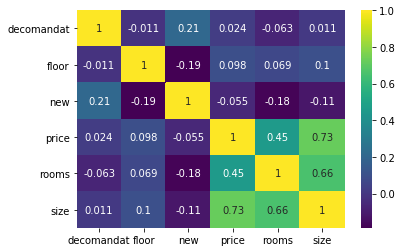

In [163]:
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.show()

In [168]:
X = np.matrix(df[['rooms', 'size']])
y = np.array(df['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 115559.855729
[Split 1] Score: 96005.403221
[Split 2] Score: 78731.006242
[Split 3] Score: 98540.429610
[Split 4] Score: 74787.324590


In [169]:
X = np.matrix(df[['rooms', 'size', 'new', 'decomandat', 'floor']])
y = np.array(df['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 115331.736786
[Split 1] Score: 96035.449300
[Split 2] Score: 78313.861824
[Split 3] Score: 98771.764504
[Split 4] Score: 77175.169079


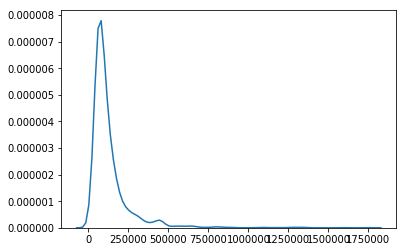

In [172]:
sns.kdeplot(y)
plt.show()

In [174]:
X = np.matrix(df.loc[df['price'] < 300000][['rooms', 'size']])
y = np.array(df.loc[df['price'] < 300000]['price'])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 39453.875820
[Split 1] Score: 42236.005708
[Split 2] Score: 40549.450425
[Split 3] Score: 52682.620407
[Split 4] Score: 41276.426672


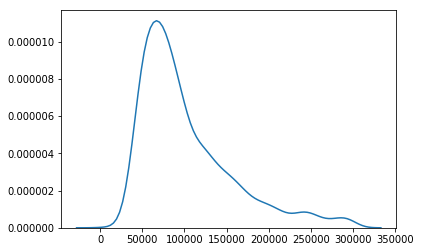

In [175]:
sns.kdeplot(y)
plt.show()

In [176]:
df.loc[df['price'] < 300000]['price'].describe()

count      3307.000000
mean     102499.993347
std       55404.713087
min        5000.000000
25%       63000.000000
50%       85000.000000
75%      127000.000000
max      299900.000000
Name: price, dtype: float64

In [178]:
X = np.matrix(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['rooms', 'size']])
y = np.array(df.loc[df['price'] < 150000].loc[df['price'] > 50000][['price']])

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegression(normalize=True)
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 24066.808637
[Split 1] Score: 24226.502154
[Split 2] Score: 22960.407509
[Split 3] Score: 23214.149965
[Split 4] Score: 22170.167075
